# MNIST Digit Classification with our own Framework

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [1]:
import os
if not os.path.exists('mnist.pkl'):
    !wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
    !gzip -d mnist.pkl.gz

In [2]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f, encoding='latin1')

In [3]:
TRAIN, TEST = 0, 1
FEATURES, LABELS = 0, 1

labels = MNIST[TRAIN][LABELS]
data = MNIST[TRAIN][FEATURES]

Let's see what is the shape of data that we have:

In [4]:
data.shape

(50000, 784)

### Splitting the Data

We will use Scikit Learn to split the data between training and test dataset:

In [5]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(data,labels,test_size=0.2)

print(f"Train samples: {len(features_train)}, test samples: {len(features_test)}")

Train samples: 40000, test samples: 10000


### Instructions

1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module
1. Define and train one-layered perceptron, observing training and validation accuracy during training
1. Try to understand if overfitting took place, and adjust layer parameters to improve accuracy
1. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.
1. Try to answer the following questions:
    - Does the inter-layer activation function affect network performance?
    - Do we need 2- or 3-layered network for this task?
    - Did you experience any problems training the network? Especially as the number of layers increased.
    - How do weights of the network behave during training? You may plot max abs value of weights vs. epoch to understand the relation.

## Implementation Starts Here

### Paste Framework Code from Lesson

In [6]:
import numpy as np
import matplotlib.pyplot as plt 

class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)

def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # remove previous plot
    while ax.lines:
        ax.lines.pop()
    # draw updated lines
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
    ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
              loc='lower center', ncol = 2)

### Define and Train One-layered Perceptron

In [14]:
def train_and_plot(train_x, train_labels, test_x, test_labels, n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim(0, n_epoch + 1)
    ax.set_ylim(0,1)

    train_acc = np.empty((n_epoch + 1, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch + 1, 3))
    valid_acc[:] = np.NAN

    # plot accuracy without any training
    tloss, taccuracy = get_loss_acc(train_x,train_labels,loss)
    train_acc[0, :] = [0, tloss, taccuracy]
    vloss, vaccuracy = get_loss_acc(test_x,test_labels,loss)
    valid_acc[0, :] = [0, vloss, vaccuracy]

    for epoch in range(1, n_epoch + 1):
        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(train_x,train_labels,loss)
        train_acc[epoch, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(test_x,test_labels,loss)
        valid_acc[epoch, :] = [epoch, vloss, vaccuracy]
        
        ax.set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax)
        fig.canvas.draw()
        fig.canvas.flush_events()

    return train_acc, valid_acc

(array([[ 0.        ,  2.37501099,  0.070725  ],
        [ 1.        ,  0.35316766,  0.902025  ],
        [ 2.        ,  0.31834503,  0.9116    ],
        [ 3.        ,  0.30253775,  0.91605   ],
        [ 4.        ,  0.29289956,  0.9187    ],
        [ 5.        ,  0.28616965,  0.92025   ],
        [ 6.        ,  0.28108401,  0.921425  ],
        [ 7.        ,  0.27703709,  0.922775  ],
        [ 8.        ,  0.27369768,  0.92365   ],
        [ 9.        ,  0.27086713,  0.9246    ],
        [10.        ,  0.26841798,  0.92545   ],
        [11.        ,  0.26626408,  0.92615   ],
        [12.        ,  0.26434474,  0.9268    ],
        [13.        ,  0.26261581,  0.92735   ],
        [14.        ,  0.26104423,  0.928125  ],
        [15.        ,  0.2596047 ,  0.92835   ],
        [16.        ,  0.25827745,  0.928825  ],
        [17.        ,  0.25704677,  0.929325  ],
        [18.        ,  0.25589998,  0.92965   ],
        [19.        ,  0.25482674,  0.9299    ],
        [20.        

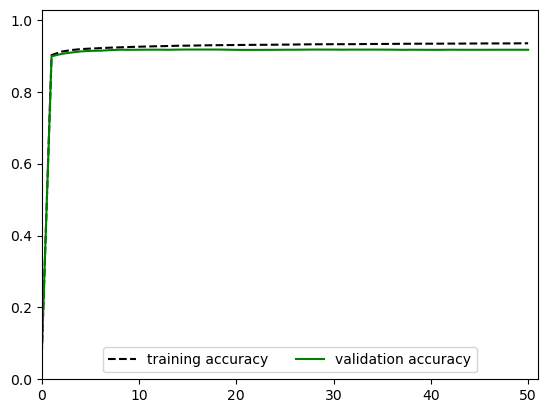

In [20]:
net = Net()
net.add(Linear(features_train[0].shape[0], 10))
net.add(Softmax())

train_and_plot(features_train, labels_train, features_test, labels_test, 50, net, lr=0.01)

**Does overfitting takes place?** No. Validation accuracy seems quite steady.

### Define and Train Two-layered Perceptron

(array([[0.00000000e+00, 2.33848816e+00, 6.52000000e-02],
        [1.00000000e+00, 2.69504722e-01, 9.23775000e-01],
        [2.00000000e+00, 2.11704666e-01, 9.40700000e-01],
        [3.00000000e+00, 1.81739095e-01, 9.48550000e-01],
        [4.00000000e+00, 1.61735805e-01, 9.54100000e-01],
        [5.00000000e+00, 1.47095992e-01, 9.58825000e-01],
        [6.00000000e+00, 1.35690937e-01, 9.62100000e-01],
        [7.00000000e+00, 1.26258877e-01, 9.64625000e-01],
        [8.00000000e+00, 1.18247642e-01, 9.66850000e-01],
        [9.00000000e+00, 1.11396647e-01, 9.69300000e-01],
        [1.00000000e+01, 1.05465854e-01, 9.70250000e-01],
        [1.10000000e+01, 1.00238118e-01, 9.71900000e-01],
        [1.20000000e+01, 9.55762429e-02, 9.72925000e-01],
        [1.30000000e+01, 9.13822633e-02, 9.74200000e-01],
        [1.40000000e+01, 8.75833821e-02, 9.75175000e-01],
        [1.50000000e+01, 8.41277454e-02, 9.76250000e-01],
        [1.60000000e+01, 8.09738944e-02, 9.76975000e-01],
        [1.700

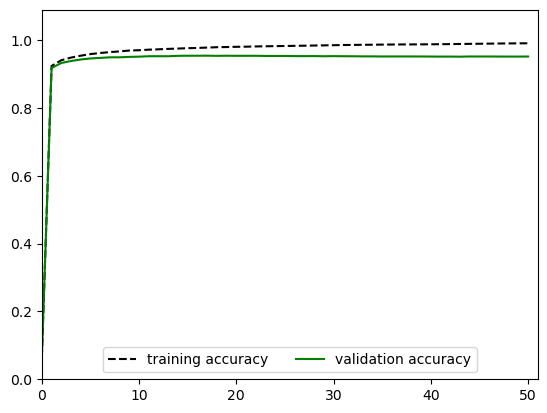

In [28]:
net = Net()
net.add(Linear(features_train[0].shape[0], 28))
net.add(Tanh())
net.add(Linear(28, 10))
net.add(Softmax())

train_and_plot(features_train, labels_train, features_test, labels_test, 50, net, lr=0.01)

**Does overfitting takes place?** No. Because making the network more complex by increasing the number of network parameters, while keeping the number of training data unchanged, actually increases both validation and training accuracy.

(array([[0.00000000e+00, 2.33667025e+00, 1.33150000e-01],
        [1.00000000e+00, 2.65549134e-01, 9.23875000e-01],
        [2.00000000e+00, 2.00873451e-01, 9.42600000e-01],
        [3.00000000e+00, 1.61380299e-01, 9.53700000e-01],
        [4.00000000e+00, 1.33913207e-01, 9.61450000e-01],
        [5.00000000e+00, 1.13664526e-01, 9.67850000e-01],
        [6.00000000e+00, 9.81881687e-02, 9.72400000e-01],
        [7.00000000e+00, 8.60181557e-02, 9.76050000e-01],
        [8.00000000e+00, 7.61782751e-02, 9.79200000e-01],
        [9.00000000e+00, 6.80193374e-02, 9.81475000e-01],
        [1.00000000e+01, 6.11126489e-02, 9.83700000e-01],
        [1.10000000e+01, 5.51617914e-02, 9.85375000e-01],
        [1.20000000e+01, 4.99564867e-02, 9.87100000e-01],
        [1.30000000e+01, 4.53543586e-02, 9.88625000e-01],
        [1.40000000e+01, 4.12617170e-02, 9.89650000e-01],
        [1.50000000e+01, 3.76132204e-02, 9.90925000e-01],
        [1.60000000e+01, 3.43574443e-02, 9.92200000e-01],
        [1.700

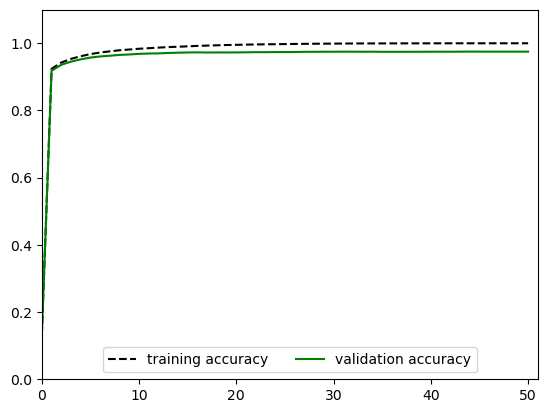

In [25]:
net = Net()
net.add(Linear(features_train[0].shape[0], 112))
net.add(Tanh())
net.add(Linear(112, 10))
net.add(Softmax())

train_and_plot(features_train, labels_train, features_test, labels_test, 50, net, lr=0.01)

### Define and Train Three-layered Perceptron

(array([[0.00000000e+00, 2.34998871e+00, 1.06725000e-01],
        [1.00000000e+00, 2.66706882e-01, 9.27575000e-01],
        [2.00000000e+00, 1.87044491e-01, 9.47825000e-01],
        [3.00000000e+00, 1.54204858e-01, 9.56975000e-01],
        [4.00000000e+00, 1.35969440e-01, 9.61025000e-01],
        [5.00000000e+00, 1.23987845e-01, 9.63875000e-01],
        [6.00000000e+00, 1.15225685e-01, 9.66200000e-01],
        [7.00000000e+00, 1.09125985e-01, 9.68000000e-01],
        [8.00000000e+00, 1.03795106e-01, 9.69200000e-01],
        [9.00000000e+00, 9.93495530e-02, 9.69750000e-01],
        [1.00000000e+01, 9.56890953e-02, 9.70300000e-01],
        [1.10000000e+01, 9.30671583e-02, 9.71025000e-01],
        [1.20000000e+01, 9.14752618e-02, 9.71475000e-01],
        [1.30000000e+01, 8.92516290e-02, 9.72000000e-01],
        [1.40000000e+01, 8.68869190e-02, 9.72275000e-01],
        [1.50000000e+01, 8.31782924e-02, 9.73550000e-01],
        [1.60000000e+01, 7.87467404e-02, 9.75075000e-01],
        [1.700

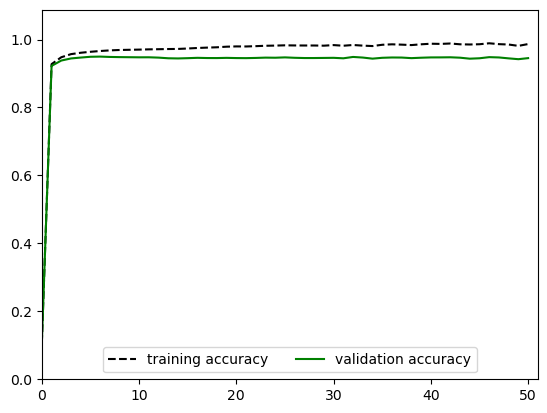

In [26]:
net = Net()
net.add(Linear(features_train[0].shape[0], 28))
net.add(Tanh())
net.add(Linear(28, 10))
net.add(Tanh())
net.add(Linear(10, 10))
net.add(Softmax())

train_and_plot(features_train, labels_train, features_test, labels_test, 50, net, lr=0.01)

**Does overfitting takes place?** No. Because making the network more complex by increasing the number of network parameters, while keeping the number of training data unchanged, actually increases both validation and training accuracy.

(array([[0.00000000e+00, 2.32118954e+00, 1.24775000e-01],
        [1.00000000e+00, 2.31610130e-01, 9.33725000e-01],
        [2.00000000e+00, 1.57973414e-01, 9.54425000e-01],
        [3.00000000e+00, 1.19366216e-01, 9.65400000e-01],
        [4.00000000e+00, 9.58655024e-02, 9.72450000e-01],
        [5.00000000e+00, 7.96832200e-02, 9.77075000e-01],
        [6.00000000e+00, 6.70684517e-02, 9.80775000e-01],
        [7.00000000e+00, 5.70191948e-02, 9.83300000e-01],
        [8.00000000e+00, 4.85684318e-02, 9.85875000e-01],
        [9.00000000e+00, 4.15196294e-02, 9.88275000e-01],
        [1.00000000e+01, 3.57389544e-02, 9.90075000e-01],
        [1.10000000e+01, 3.08059301e-02, 9.91575000e-01],
        [1.20000000e+01, 2.64655368e-02, 9.93425000e-01],
        [1.30000000e+01, 2.25795828e-02, 9.94800000e-01],
        [1.40000000e+01, 1.91344500e-02, 9.95775000e-01],
        [1.50000000e+01, 1.61219553e-02, 9.96850000e-01],
        [1.60000000e+01, 1.36126853e-02, 9.97650000e-01],
        [1.700

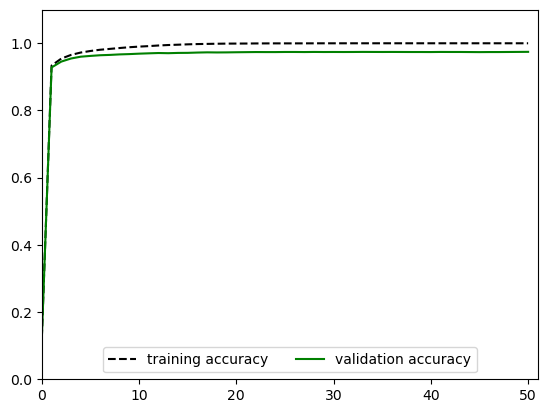

In [27]:
net = Net()
net.add(Linear(features_train[0].shape[0], 112))
net.add(Tanh())
net.add(Linear(112, 28))
net.add(Tanh())
net.add(Linear(28, 10))
net.add(Softmax())

train_and_plot(features_train, labels_train, features_test, labels_test, 50, net, lr=0.01)

### Try to Answer the Questions

#### Does Activation Function Affects Network Performance?

(array([[ 0.        ,  2.35641144,  0.09425   ],
        [ 1.        ,  0.31516688,  0.911425  ],
        [ 2.        ,  0.29267543,  0.918725  ],
        [ 3.        ,  0.28137827,  0.921575  ],
        [ 4.        ,  0.27410325,  0.923925  ],
        [ 5.        ,  0.26886155,  0.926025  ],
        [ 6.        ,  0.26484355,  0.927325  ],
        [ 7.        ,  0.26163693,  0.928375  ],
        [ 8.        ,  0.25900144,  0.929125  ],
        [ 9.        ,  0.2567851 ,  0.9295    ],
        [10.        ,  0.25488627,  0.929825  ],
        [11.        ,  0.25323419,  0.92985   ],
        [12.        ,  0.25177808,  0.93025   ],
        [13.        ,  0.25048061,  0.930475  ],
        [14.        ,  0.24931372,  0.93075   ],
        [15.        ,  0.24825596,  0.930925  ],
        [16.        ,  0.24729058,  0.9312    ],
        [17.        ,  0.24640434,  0.931525  ],
        [18.        ,  0.24558656,  0.93175   ],
        [19.        ,  0.24482856,  0.93195   ],
        [20.        

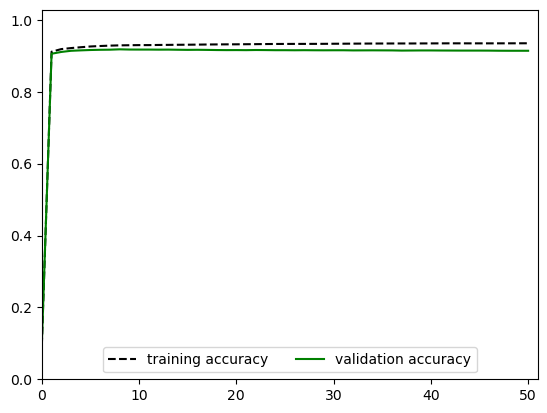

In [32]:
net = Net()
net.add(Linear(features_train[0].shape[0], 112))
net.add(Linear(112, 10))
net.add(Softmax())

train_and_plot(features_train, labels_train, features_test, labels_test, 50, net, lr=0.01)

In [29]:
class Sigmoid:
    def forward(self,x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    def backward(self,dy):
        return self.y * (1 - self.y) * dy

class Relu:
    def forward(self,x):
        self.x = x
        return np.maximum(0, x)
    def backward(self,dy):
        return (self.x >= 0) * dy

(array([[0.00000000e+00, 2.42957419e+00, 9.76500000e-02],
        [1.00000000e+00, 4.00638413e-01, 8.91975000e-01],
        [2.00000000e+00, 3.21551926e-01, 9.09075000e-01],
        [3.00000000e+00, 2.86243784e-01, 9.17725000e-01],
        [4.00000000e+00, 2.61430877e-01, 9.24275000e-01],
        [5.00000000e+00, 2.41195954e-01, 9.30150000e-01],
        [6.00000000e+00, 2.23899730e-01, 9.35100000e-01],
        [7.00000000e+00, 2.08804540e-01, 9.39775000e-01],
        [8.00000000e+00, 1.95442550e-01, 9.43950000e-01],
        [9.00000000e+00, 1.83496191e-01, 9.47100000e-01],
        [1.00000000e+01, 1.72742966e-01, 9.50025000e-01],
        [1.10000000e+01, 1.63017714e-01, 9.53025000e-01],
        [1.20000000e+01, 1.54190092e-01, 9.55525000e-01],
        [1.30000000e+01, 1.46152191e-01, 9.58275000e-01],
        [1.40000000e+01, 1.38812271e-01, 9.60100000e-01],
        [1.50000000e+01, 1.32091498e-01, 9.62275000e-01],
        [1.60000000e+01, 1.25921620e-01, 9.64425000e-01],
        [1.700

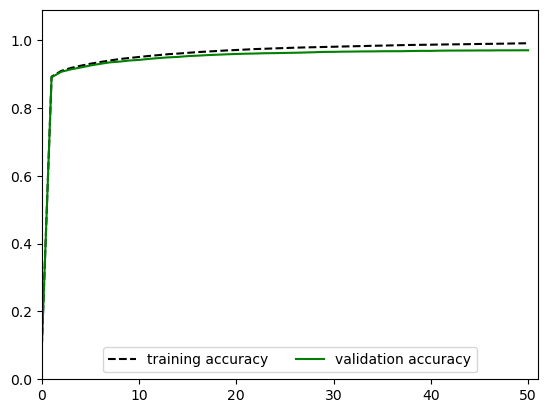

In [30]:
net = Net()
net.add(Linear(features_train[0].shape[0], 112))
net.add(Sigmoid())
net.add(Linear(112, 10))
net.add(Softmax())

train_and_plot(features_train, labels_train, features_test, labels_test, 50, net, lr=0.01)

(array([[0.00000000e+00, 2.31610173e+00, 9.42750000e-02],
        [1.00000000e+00, 2.37775637e-01, 9.32250000e-01],
        [2.00000000e+00, 1.64209045e-01, 9.53075000e-01],
        [3.00000000e+00, 1.27272786e-01, 9.63625000e-01],
        [4.00000000e+00, 1.03514358e-01, 9.70975000e-01],
        [5.00000000e+00, 8.69247020e-02, 9.75575000e-01],
        [6.00000000e+00, 7.39830920e-02, 9.78825000e-01],
        [7.00000000e+00, 6.39486068e-02, 9.81875000e-01],
        [8.00000000e+00, 5.59974028e-02, 9.84125000e-01],
        [9.00000000e+00, 4.92245204e-02, 9.86450000e-01],
        [1.00000000e+01, 4.36594903e-02, 9.88050000e-01],
        [1.10000000e+01, 3.89690594e-02, 9.89250000e-01],
        [1.20000000e+01, 3.48163919e-02, 9.90650000e-01],
        [1.30000000e+01, 3.13471852e-02, 9.91925000e-01],
        [1.40000000e+01, 2.82491454e-02, 9.93050000e-01],
        [1.50000000e+01, 2.55573241e-02, 9.93875000e-01],
        [1.60000000e+01, 2.32353611e-02, 9.94575000e-01],
        [1.700

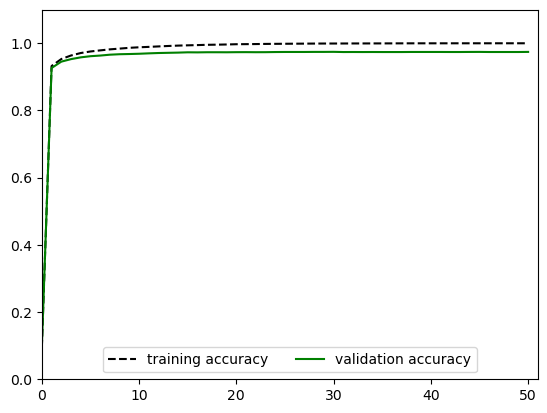

In [31]:
net = Net()
net.add(Linear(features_train[0].shape[0], 112))
net.add(Relu())
net.add(Linear(112, 10))
net.add(Softmax())

train_and_plot(features_train, labels_train, features_test, labels_test, 50, net, lr=0.01)

Activation function affects network performance. If there is no activation function, multiple linear layers can only produces a linear function, so multiple-layered module has the same performance as the single layer module. Different activation function also have different performances. In this example, `tanh` and `relu` performs quite well while `sigmoid` performs slightly worse.

#### Do We Need 2- Or 3-layered Network for This Task?

We need a 2-layered network because it introduces activation function and generates a non-linear function. It seems that we don't need 3 or more layers as they have similar performances with the 2-layered network.

#### Any Problems Training the Network? Especially as the Number of Layers Increased.

The training process becomes slower as the number of network layers increase.

#### How Do Weights of the Network Behave During Training?

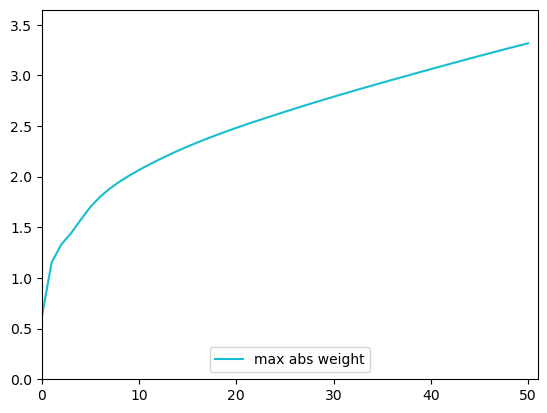

In [42]:
def get_max_abs_weight(net):
    ret = 0
    for layer in net.layers:
        if isinstance(layer, Linear):
            ret = max(ret, np.max(np.abs(layer.W)), np.max(np.abs(layer.b)))
    return ret

def plot_max_abs_weight(x, y, fig, ax):
    # remove previous plot
    while ax.lines:
        ax.lines.pop()
    # draw updated lines
    ax.plot(x, y)
    ax.legend(ax.lines, ['max abs weight'], loc='lower center', ncol = 1)

def train_and_plot_max_abs_weight(train_x, train_labels, n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim(0, n_epoch + 1)
    ax.set_ylim(0,1)

    max_abs_weights = np.empty((n_epoch + 1, 2))
    max_abs_weights[:] = np.NAN

    # plot max abs weight without any training
    max_abs_weights[0, :] = [0, get_max_abs_weight(net)]

    for epoch in range(1, n_epoch + 1):
        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        max_abs_weights[epoch, :] = [epoch, get_max_abs_weight(net)]
        
        ax.set_ylim(0, max(max_abs_weights[:, 1]) * 1.1)

        plot_max_abs_weight(max_abs_weights[:, 0], max_abs_weights[:, 1], fig, ax)
        fig.canvas.draw()
        fig.canvas.flush_events()

net = Net()
net.add(Linear(features_train[0].shape[0], 28))
net.add(Tanh())
net.add(Linear(28, 10))
net.add(Softmax())

train_and_plot_max_abs_weight(features_train, labels_train, 50, net, lr=0.01)

The maximum absolute weight increases as the number of epoches increases.